In [1]:
# Download ESOL dataset from http://moleculenet.ai/datasets-1

!wget https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/ESOL.zip -O ESOL.zip
!unzip ESOL.zip

In [2]:
# Install Miniconda

!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh && bash miniconda.sh -bfp /usr/local

In [3]:
# Install required packages

!conda install -y -c conda-forge rdkit
!conda install -y -c openbabel openbabel

In [0]:
# Update path so we can see conda packages

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [0]:
# Some common imports and functions

SEED = 42

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import Chem

def split_data(X,y):
  X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED)
  return X_train, X_test, y_train, y_test

def generate_scaffold(smiles):
  mol = Chem.MolFromSmiles(smiles)
  scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
  return scaffold


def scaffold_split(X, y, train_ratio=0.8):
    X = np.array(X)
    y = np.array(y)

    scaffolds = {}

    for ind, smi in tqdm(enumerate(X), total=len(X)):
        scaffold = generate_scaffold(smi)

        sc = scaffolds.get(scaffold, [])
        scaffolds[scaffold] = sc + [ind]

    scaffolds_keys = list(scaffolds)
    rng = np.random.RandomState(SEED)
    rng.shuffle(scaffolds_keys)

    print("Found {} scaffolds in {} rows".format(len(scaffolds_keys), len(X)))
    # logger.info(scaffolds_keys)

    train_cutoff = train_ratio * len(X)
    train_inds, test_inds = [], []
    for scaffold_key in scaffolds_keys:
        if len(train_inds) > train_cutoff:
            test_inds += scaffolds[scaffold_key]
        else:
            train_inds += scaffolds[scaffold_key]
    
    print(train_inds)

    train_x = [X[i] for i in train_inds]
    train_y = [y[i] for i in train_inds]
    test_x = [X[i] for i in test_inds]
    test_y = [y[i] for i in test_inds]

    return train_x, test_x, train_y, test_y


In [0]:
# Create dataset in format (smiles, solubility)

import csv

data_x = []
data_y = []

with open('delaney-processed.csv') as in_file:
  rdr = csv.reader(in_file)

  # skip headers
  next(rdr)

  for line in rdr:
    data_x.append(line[-1])
    data_y.append(float(line[1]))

In [0]:
import pandas as pd

df = pd.read_csv('delaney-processed.csv')
display(df)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [0]:
print(len(data_y))

1128


In [0]:
# standarize the data

from scipy import stats

data_y = stats.zscore(data_y)

In [0]:
train_x, test_x, train_y, test_y = scaffold_split(data_x, data_y)


Found 269 scaffolds in 1128 rows
[53, 107, 149, 317, 511, 727, 739, 382, 219, 427, 678, 456, 755, 813, 89, 288, 300, 723, 622, 981, 637, 1116, 852, 226, 483, 662, 659, 988, 1113, 331, 409, 135, 1098, 656, 91, 411, 81, 145, 224, 507, 513, 551, 685, 798, 932, 647, 9, 38, 718, 343, 43, 230, 270, 304, 312, 431, 532, 753, 947, 1026, 373, 174, 486, 660, 828, 732, 6, 20, 40, 54, 60, 69, 77, 97, 119, 166, 215, 234, 297, 319, 324, 397, 417, 503, 547, 559, 560, 568, 586, 603, 661, 668, 729, 824, 862, 870, 871, 879, 907, 908, 911, 962, 970, 1042, 1120, 400, 172, 398, 394, 47, 243, 997, 422, 578, 32, 1110, 206, 792, 799, 899, 262, 963, 604, 286, 353, 562, 1093, 21, 512, 943, 866, 990, 381, 65, 644, 481, 523, 706, 1025, 1034, 26, 115, 1027, 1038, 195, 360, 499, 10, 874, 164, 530, 543, 558, 634, 186, 326, 28, 320, 916, 370, 977, 254, 756, 114, 358, 389, 390, 682, 768, 298, 719, 72, 797, 515, 248, 1002, 279, 725, 424, 493, 627, 740, 746, 885, 418, 710, 728, 213, 976, 633, 761, 346, 863, 502, 1095, 5

In [0]:
print(np.array(train_x).shape, np.array(test_x).shape, np.array(train_y).shape, np.array(test_y).shape)

(992,) (136,) (992,) (136,)


# MODELS

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import math


def create_baseline_model():
  def calc_mse(train_x, train_y, test_x, test_y):
    knn = KNeighborsRegressor(n_neighbors=1)
    knn.fit(train_x, train_y) 
    pred_y = knn.predict(test_x)
    return mean_squared_error(test_y, pred_y)
  return calc_mse

def create_random_forest_model():
  def calc_mse(train_x, train_y, test_x, test_y):
    regr = RandomForestRegressor(random_state=SEED)
    regr.fit(train_x, train_y) 
    pred_y = regr.predict(test_x)
    return mean_squared_error(test_y, pred_y)
  return calc_mse

def create_svm_model():
  def calc_mse(train_x, train_y, test_x, test_y):
    svr = SVR()
    svr.fit(train_x, train_y) 
    pred_y = svr.predict(test_x)
    return mean_squared_error(test_y, pred_y)
  return calc_mse

# Fingerprints


In [0]:
import tempfile
import openbabel
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from functools import reduce


# SMILES embedding

smiles_vocabulary = list(set(reduce(str.__add__, train_x, '')))
smiles_vocab_len = len(smiles_vocabulary)

def create_smiles_fingerprint(max_length=100):
  def create_single(smiles):
    vec = [smiles_vocabulary.index(c) for c in smiles]
    vec = (vec + ([-1] * max_length))[:max_length]
    assert len(vec) == max_length
    return vec
  return create_single

# MACCS

def create_maccs_fingerprint():
  def create_single(smiles):
    m = Chem.MolFromSmiles(smiles)
    maccs = MACCSkeys.GenMACCSKeys(m)
    bits = maccs.ToBitString()
    return np.array(list(bits)).astype(np.int32)
  return create_single

# ECFP

def create_ecfp_fingerprint(range=2, n_bits=1024):
  def create_single(smiles):
    m = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, range, nBits=n_bits)
    return np.array(fp)
  return create_single

# Spectrophore

def create_spectrophore_fingerprint():
    def create_single(smiles):
        # we have to do some shenanigans here...
        # first, convert SMILES to 3D .sdf file
        m = Chem.MolFromSmiles(smiles)
        m2 = Chem.AddHs(m)
        AllChem.EmbedMolecule(m2)
        AllChem.MMFFOptimizeMolecule(m2)
        with tempfile.NamedTemporaryFile(suffix='.sdf') as fp:
            w = Chem.SDWriter(fp.name)
            w.write(m2)
            # then, create spectrophore from that
            sp = openbabel.OBSpectrophore()
            conv = openbabel.OBConversion()
            mol = openbabel.OBMol()
            conv.ReadFile(mol, fp.name)
            return np.array(sp.GetSpectrophore(mol)).astype(np.float32)
    return create_single


# SMILES evaluation

In [0]:
smiles_fingerprinting = create_smiles_fingerprint()

smiles_train_x = np.array([smiles_fingerprinting(x) for x in train_x])
smiles_test_x = np.array([smiles_fingerprinting(x) for x in test_x])



In [0]:
smiles_fingerprinting('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')

In [0]:
baseline_model = create_baseline_model()

smiles_baseline_mse = baseline_model(smiles_train_x, train_y, smiles_test_x, test_y)

print('SMILES baseline MSE:', smiles_baseline_mse)

SMILES baseline MSE: 0.9507462628251713


In [0]:
rf_model = create_random_forest_model()

smiles_rf_mse = rf_model(smiles_train_x, train_y, smiles_test_x, test_y)

print('SMILES random forest MSE:', smiles_rf_mse)

SMILES random forest MSE: 0.6572800237837585


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
svm_model = create_svm_model()

smiles_svm_mse = svm_model(smiles_train_x, train_y, smiles_test_x, test_y)

print('SMILES SVM MSE:', smiles_svm_mse)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SMILES SVM MSE: 1.0658020123031218


# MACCS evaluation



In [0]:
maccs_fingerprinting = create_maccs_fingerprint()

maccs_train_x = np.array([maccs_fingerprinting(x) for x in train_x])
maccs_test_x = np.array([maccs_fingerprinting(x) for x in test_x])

In [0]:
baseline_model = create_baseline_model()

maccs_baseline_mse = baseline_model(maccs_train_x, train_y, maccs_test_x, test_y)

print('MACCS baseline MSE:', maccs_baseline_mse)


MACCS baseline MSE: 0.6721882207585247


In [0]:
rf_model = create_random_forest_model()

maccs_rf_mse = rf_model(maccs_train_x, train_y, maccs_test_x, test_y)

print('MACCS random forest MSE:', maccs_rf_mse)


MACCS random forest MSE: 0.48706447816738724


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
svm_model = create_svm_model()

maccs_svm_mse = svm_model(maccs_train_x, train_y, maccs_test_x, test_y)

print('MACCS SVM MSE:', maccs_svm_mse)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MACCS SVM MSE: 0.5011612422565129


# ECFP evaluation


In [0]:
ecfp_fingerprinting = create_ecfp_fingerprint()

ecfp_train_x = np.array([ecfp_fingerprinting(x) for x in train_x])
ecfp_test_x = np.array([ecfp_fingerprinting(x) for x in test_x])

In [0]:
baseline_model = create_baseline_model()

ecfp_baseline_mse = baseline_model(ecfp_train_x, train_y, ecfp_test_x, test_y)

print('MACCS baseline MSE:', ecfp_baseline_mse)

MACCS baseline MSE: 0.9561634357639078


In [0]:
rf_model = create_random_forest_model()

ecfp_rf_mse = rf_model(ecfp_train_x, train_y, ecfp_test_x, test_y)

print('MACCS random forest MSE:', ecfp_rf_mse)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MACCS random forest MSE: 0.7091179833851211


In [0]:
svm_model = create_svm_model()

ecfp_svm_mse = svm_model(ecfp_train_x, train_y, ecfp_test_x, test_y)

print('MACCS SVM MSE:', ecfp_svm_mse)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MACCS SVM MSE: 0.8450060675514988


In [0]:
def get_ecfp_results(range=2, n_bits=1024):
  ecfp_fingerprinting = create_ecfp_fingerprint(range=range, n_bits=n_bits)
  ecfp_train_x = np.array([ecfp_fingerprinting(x) for x in train_x])
  ecfp_test_x = np.array([ecfp_fingerprinting(x) for x in test_x])

  baseline_model = create_baseline_model()
  ecfp_baseline_mse = baseline_model(ecfp_train_x, train_y, ecfp_test_x, test_y)

  rf_model = create_random_forest_model()
  ecfp_rf_mse = rf_model(ecfp_train_x, train_y, ecfp_test_x, test_y)

  svm_model = create_svm_model()
  ecfp_svm_mse = svm_model(ecfp_train_x, train_y, ecfp_test_x, test_y)
  
  return ecfp_baseline_mse, ecfp_rf_mse, ecfp_svm_mse

In [0]:
ecfp_lengths = [128, 256, 512, 1024, 2048, 4096]

baseline_results = []
rf_results = []
svm_results = []
for fp_length in tqdm(ecfp_lengths):
  baseline_result, rf_result, svm_result = get_ecfp_results(n_bits=fp_length)
  baseline_results.append(baseline_result)
  rf_results.append(rf_result)
  svm_results.append(svm_result)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to 

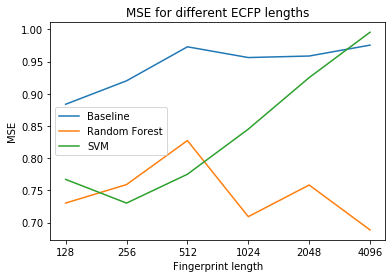

In [0]:
fig, ax = plt.subplots()
plt.plot(baseline_results, label='Baseline')
plt.plot(rf_results, label='Random Forest')
plt.plot(svm_results, label="SVM")
plt.ylabel('MSE')
plt.xlabel('Fingerprint length')
plt.title('MSE for different ECFP lengths')
ax.set_xticklabels([0] + ecfp_lengths)
plt.legend()
plt.show()

In [0]:
ecfp_ranges = [1, 2, 3, 4, 5, 6]

baseline_results = []
rf_results = []
svm_results = []

for fp_range in tqdm(ecfp_ranges):
  baseline_result, rf_result, svm_result = get_ecfp_results(range=fp_range)
  baseline_results.append(baseline_result)
  rf_results.append(rf_result)
  svm_results.append(svm_result)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to 

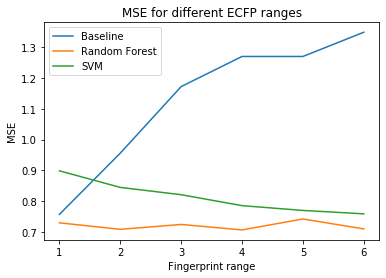

In [0]:
fig, ax = plt.subplots()
plt.plot(baseline_results, label='Baseline')
plt.plot(rf_results, label='Random Forest')
plt.plot(svm_results, label='SVM')
plt.ylabel('MSE')
plt.xlabel('Fingerprint range')
plt.title('MSE for different ECFP ranges')
ax.set_xticks(range(len(ecfp_ranges)))
ax.set_xticklabels(ecfp_ranges)
plt.legend()
plt.show()

# Spectrophore evaluation

In [0]:
spec_fingerprinting = create_spectrophore_fingerprint()

spec_train_x = np.array([spec_fingerprinting(x) for x in tqdm(train_x)])
spec_test_x = np.array([spec_fingerprinting(x) for x in tqdm(test_x)])

In [0]:
# filter wrong ones 

wrong_train = [i for i, x in enumerate(spec_train_x) if len(x) == 0]
wrong_test = [i for i, x in enumerate(spec_test_x) if len(x) == 0]

spec_train_x_clean = np.array(list(np.delete(spec_train_x.copy(), wrong_train)))
train_y_clean = np.delete(train_y.copy(), wrong_train)
spec_test_x_clean = np.array(list(np.delete(spec_test_x.copy(), wrong_test)))
test_y_clean = np.delete(test_y.copy(), wrong_test)

In [0]:
baseline_model = create_baseline_model()

spec_baseline_mse = baseline_model(spec_train_x_clean, train_y_clean, spec_test_x_clean, test_y_clean)

print('Spectrophore baseline MSE:', spec_baseline_mse)

Spectrophore baseline MSE: 0.9236406920572603


In [0]:
rf_model = create_random_forest_model()

spec_rf_mse = rf_model(spec_train_x_clean, train_y_clean, spec_test_x_clean, test_y_clean)

print('Spectrophore random forest MSE:', spec_rf_mse)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Spectrophore random forest MSE: 0.4719166022725669


In [0]:
svm_model = create_svm_model()

spec_svm_mse = svm_model(spec_train_x_clean, train_y_clean, spec_test_x_clean, test_y_clean)

print('Spectrophore SVM MSE:', spec_svm_mse)

Spectrophore SVM MSE: 1.0682103882812657


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
def read_data(filen):
  X = []
  y = []
  with open(filen, 'r') as train_f:
    rdr = csv.reader(train_f)
    next(rdr)
    for line in rdr:
      X.append(line[0])
      y.append(line[1])
  return X, y

You need to save your train and test sets as `train.csv` and `test.csv`.

In [0]:
train_x, train_y = read_data('train.csv')
test_x, test_y = read_data('test.csv')

print(len(train_x))

902


In [0]:
ecfp_fp = create_ecfp_fingerprint(range=3, n_bits=1024)

train_x_ecfp = [ecfp_fp(x) for x in train_x]
test_x_ecfp = [ecfp_fp(x) for x in test_x]
train_y = np.array(train_y).astype(np.float32)
test_y = np.array(test_y).astype(np.float32)

baseline_model = create_baseline_model()

ecfp_baseline_mse = baseline_model(train_x_ecfp, train_y, test_x_ecfp, test_y)

print('ECFP baseline MSE:', ecfp_baseline_mse)

rf_model = create_random_forest_model()

ecfp_rf_mse = rf_model(train_x_ecfp, train_y, test_x_ecfp, test_y)

print('ECFP random forest MSE:', ecfp_rf_mse)

ECFP baseline MSE: 0.76636446


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ECFP random forest MSE: 0.2786841987011741


In [0]:
ecfp_fp = create_maccs_fingerprint()

train_x_ecfp = [ecfp_fp(x) for x in train_x]
test_x_ecfp = [ecfp_fp(x) for x in test_x]
train_y = np.array(train_y).astype(np.float32)
test_y = np.array(test_y).astype(np.float32)

baseline_model = create_baseline_model()

ecfp_baseline_mse = baseline_model(train_x_ecfp, train_y, test_x_ecfp, test_y)

print('MACCS baseline MSE:', ecfp_baseline_mse)

rf_model = create_random_forest_model()

ecfp_rf_mse = rf_model(train_x_ecfp, train_y, test_x_ecfp, test_y)

print('MACCS random forest MSE:', ecfp_rf_mse)

MACCS baseline MSE: 0.34932372
MACCS random forest MSE: 0.22252427080072024


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
